<a href="https://colab.research.google.com/github/ivansirait/Analisis_kebiasaan_saat_belajar_vs_Prestasi_Akademik-Siswa/blob/Try-before-Main/DasiDalis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import pandas as pd
from google.colab import files

uploaded = files.upload()

# Ambil nama file
filename = list(uploaded.keys())[0]

# Membaca file Excel
df = pd.read_csv(filename)
# df = pd.read_csv("tes.csv")

df.info()


Saving tes.csv to tes (1).csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1252 entries, 0 to 1251
Data columns (total 22 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   Timestamp                                                      1252 non-null   object 
 1   Nama Lengkap                                                   1249 non-null   object 
 2   Jenis Kelamin                                                  1252 non-null   object 
 3   Jenis Sekolah Menengah atas yang anda tempuh                   1251 non-null   object 
 4   Asal Sekolah                                                   1248 non-null   object 
 5   Tingkat Kelas                                                  1249 non-null   object 
 6   Gaya belajar yang biasanya digunakan                           1247 non-null   object 
 7   Teknik belajar yang biasanya d

In [34]:
print("Missing values awal:")
print(df.isnull().sum())
print("Nama nama duplikat ada : ",df["Nama Lengkap"].duplicated().sum())
df = df.drop_duplicates(subset="Nama Lengkap", keep="first")
print("Jumlah nama duplikat di akhir:",df["Nama Lengkap"].duplicated().sum())
df.info()

Missing values awal:
Timestamp                                                          0
Nama Lengkap                                                       3
Jenis Kelamin                                                      0
Jenis Sekolah Menengah atas yang anda tempuh                       1
Asal Sekolah                                                       4
Tingkat Kelas                                                      3
Gaya belajar yang biasanya digunakan                               5
Teknik belajar yang biasanya digunakan                             5
Apakah kamu belajar sendiri atau dengan bantuan orang lain?        1
Lokasi Belajar                                                     4
Jam Belajar                                                        2
Total Waktu untuk mengerjakan Pekerjaan Rumah(PR)/Hari             1
Total Waktu untuk Belajar Mandiri /Hari                            2
Catatan singkat tentang Belajar                                  247
Mood Saat Bel

In [35]:
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype(str).str.strip()

typeint = [
    "Mood Saat Belajar",
    "Pikiran atau Stres Akademik",
    "Jumlah prestasi di dalam sekolah",
    "Jumlah prestasi di luar sekolah"
]

for col in typeint:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

perilaku = ["Mood Saat Belajar", "Pikiran atau Stres Akademik"]
for col in perilaku:
    if col in df.columns:
        df[col] = df[col].fillna(3).astype("int64")

prestasi = [
    "Jumlah prestasi di dalam sekolah",
    "Jumlah prestasi di luar sekolah"
]

for col in prestasi:
    if col in df.columns:
        df[col] = df[col].fillna(0).astype("int64")

if "Rata rata nilai Siswa(nilai tarakhir)" in df.columns:
    df["Rata rata nilai Siswa(nilai tarakhir)"] = (
        df["Rata rata nilai Siswa(nilai tarakhir)"]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .pipe(pd.to_numeric, errors="coerce")
    )
    df = df.dropna(subset=["Rata rata nilai Siswa(nilai tarakhir)"])

df = df.dropna(subset=["Jenis Sekolah Menengah atas yang anda tempuh"])

cols_teks = [
    "Catatan singkat tentang Belajar",
    "Prestasi yang diraih didalam sekolah",
    "Prestasi yang diraih diluar sekolah"
]

cols_teks_ada = [c for c in cols_teks if c in df.columns]
if cols_teks_ada:
    df[cols_teks_ada] = df[cols_teks_ada].fillna("Tidak Ada")

print(df.isnull().sum())
df.info()


Timestamp                                                        0
Nama Lengkap                                                     0
Jenis Kelamin                                                    0
Jenis Sekolah Menengah atas yang anda tempuh                     0
Asal Sekolah                                                     0
Tingkat Kelas                                                    0
Gaya belajar yang biasanya digunakan                             0
Teknik belajar yang biasanya digunakan                           0
Apakah kamu belajar sendiri atau dengan bantuan orang lain?      0
Lokasi Belajar                                                   0
Jam Belajar                                                      0
Total Waktu untuk mengerjakan Pekerjaan Rumah(PR)/Hari           0
Total Waktu untuk Belajar Mandiri /Hari                          0
Catatan singkat tentang Belajar                                  0
Mood Saat Belajar                                             

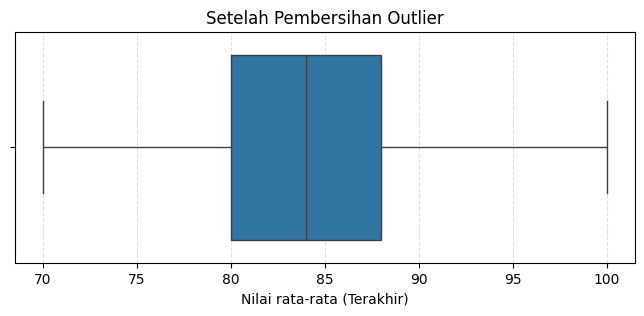

In [36]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = ['Rata rata nilai Siswa(nilai tarakhir)']

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

for col in numeric_cols:
    df = remove_outliers_iqr(df, col)

plt.figure(figsize=(8, 3))
sns.boxplot(x=df["Rata rata nilai Siswa(nilai tarakhir)"])
plt.title("Setelah Pembersihan Outlier")
plt.xlabel("Nilai rata-rata (Terakhir)")
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.show()


In [37]:
from sklearn.preprocessing import MinMaxScaler

num_cols = df.select_dtypes(include=["int64", "float64"]).columns

scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [ ]:
# df["Asal Sekolah"].value_counts()

In [38]:
import pandas as pd
import numpy as np
import unicodedata

def normalize_text(x):
    if pd.isna(x):
        return np.nan
    x = str(x).lower().strip()
    x = unicodedata.normalize("NFKC", x)
    x = x.replace("\xa0", " ")
    while "  " in x:
        x = x.replace("  ", " ")
    if x == "nan":
        return np.nan
    return x

for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].apply(normalize_text)

def map_gaya(x):
    if pd.isna(x):
        return np.nan
    if "visual" in x:
        return "visual"
    if "auditory" in x:
        return "auditory"
    if "kinestetik" in x:
        return "kinestetik"
    return "lainnya"

df["Gaya belajar yang biasanya digunakan"] = (
    df["Gaya belajar yang biasanya digunakan"].apply(map_gaya)
)

def map_teknik(x):
    if pd.isna(x):
        return np.nan
    if "pomodoro" in x or "podomoro" in x:
        return "podomoro"
    if "active recall" in x:
        return "active_recall"
    if "feynman" in x:
        return "feynman"
    if "latihan soal" in x:
        return "latihan_soal"
    if "spaced" in x:
        return "spaced_repetition"
    return "lainnya"

df["Teknik belajar yang biasanya digunakan"] = (
    df["Teknik belajar yang biasanya digunakan"].apply(map_teknik)
)

def map_asal_sekolah(x):
    if pd.isna(x):
        return "lainnya"

    if "bintang timur" in x and "sma" in x and "balige" in x:
        return "sma_sw_bintang_timur_balige"

    if "yapim" in x and "smk" in x:
        return "smk_yapim_balige"

    if "laguboti" in x and "smk" in x and "1" in x:
        return "smk_n_1_laguboti"

    if "arjuna" in x and "smk" in x:
        return "smk_arjuna_laguboti"

    return "lainnya"

df["Asal Sekolah"] = df["Asal Sekolah"].apply(map_asal_sekolah)

def map_lokasi(x):
    if pd.isna(x):
        return "lainnya"

    if any(k in x for k in ["rumah", "kamar", "kost", "meja"]):
        return "rumah"
    if any(k in x for k in ["sekolah", "kelas", "ruang kelas", "bengkel"]):
        return "sekolah"
    if "asrama" in x:
        return "asrama"
    if any(k in x for k in ["les", "bimbel"]):
        return "bimbel_les"
    if "perpustakaan" in x:
        return "perpustakaan"
    if any(k in x for k in ["taman", "kafe", "outdoor"]):
        return "outdoor"

    return "lainnya"

df["Lokasi Belajar"] = df["Lokasi Belajar"].apply(map_lokasi)

mapping_waktu = {
    "< 15 menit": 1,
    "15 - 30 menit": 2,
    "30 - 60 menit": 3,
    "> 60 menit": 4
}

for col in [
    "Total Waktu untuk mengerjakan Pekerjaan Rumah(PR)/Hari",
    "Total Waktu untuk Belajar Mandiri /Hari"
]:
    if col in df.columns:
        df[col] = df[col].map(mapping_waktu)

for col in [
    "Jumlah prestasi di dalam sekolah *",
    "Jumlah prestasi di luar sekolah"
]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

one_hot_cols = [
    "Gaya belajar yang biasanya digunakan",
    "Teknik belajar yang biasanya digunakan",
    "Jenis Kelamin",
    "Jam Belajar",
    "Jenis Sekolah Menengah atas yang anda tempuh",
    "Apakah kamu belajar sendiri atau dengan bantuan orang lain?",
    "Lokasi Belajar",
    "Asal Sekolah",
    "Apakah Anda pernah meraih prestasi di dalam atau luar sekolah"
]

df = pd.get_dummies(
    df,
    columns=[c for c in one_hot_cols if c in df.columns],
    drop_first=False
)

print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 1251
Data columns (total 44 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Timestamp                                                            889 non-null    object 
 1   Nama Lengkap                                                         888 non-null    object 
 2   Tingkat Kelas                                                        888 non-null    object 
 3   Apakah kamu belajar sendiri atau dengan bantuan orang lain?          889 non-null    object 
 4   Total Waktu untuk mengerjakan Pekerjaan Rumah(PR)/Hari               889 non-null    int64  
 5   Total Waktu untuk Belajar Mandiri /Hari                              889 non-null    int64  
 6   Catatan singkat tentang Belajar                                      752 non-null    object 
 7   Mood Saat Be

,Timestamp,Nama Lengkap,Tingkat Kelas,Apakah kamu belajar sendiri atau dengan bantuan orang lain?,Total Waktu untuk mengerjakan Pekerjaan Rumah(PR)/Hari,Total Waktu untuk Belajar Mandiri /Hari,Catatan singkat tentang Belajar,Mood Saat Belajar,Pikiran atau Stres Akademik,Rata rata nilai Siswa(nilai tarakhir),...,Lokasi Belajar_rumah,Lokasi Belajar_sekolah,Asal Sekolah_lainnya,Asal Sekolah_sma_sw_bintang_timur_balige,Asal Sekolah_smk_arjuna_laguboti,Asal Sekolah_smk_n_1_laguboti,Asal Sekolah_smk_yapim_balige,Apakah Anda pernah meraih prestasi di dalam atau luar sekolah_80,Apakah Anda pernah meraih prestasi di dalam atau luar sekolah_tidak,Apakah Anda pernah meraih prestasi di dalam atau luar sekolah_ya
0,04/12/2025 13:59:33,jonatan ambarita,xl,bersama teman,3,2,belajar membuat kita jadi hidup,0.75,0.75,0.600000,...,True,False,True,False,False,False,False,False,True,False
1,05/12/2025 8:53:12,selsa angelicha manurung,xll,sendiri,2,2,belajar membuat saya dapat memahami dalam hal ...,0.50,0.50,0.566667,...,True,False,True,False,False,False,False,False,False,True
2,05/12/2025 8:58:09,aksirapi napitupulu,xll,sendiri,2,1,fokus dan jangan ter distraksi,0.75,0.50,0.725000,...,True,False,True,False,False,False,False,False,False,True
3,05/12/2025 9:00:46,yohana marpaung,xll,sendiri,2,1,"belajar adalah proses memperoleh pengetahuan, ...",0.50,0.50,0.666667,...,True,False,True,False,False,False,False,False,False,True
5,05/12/2025 9:14:07,agung kristian panjaitan,xll,sendiri,4,3,work lost,0.75,0.50,0.633333,...,False,False,True,False,False,False,False,False,True,False


In [39]:
print(df.columns)


Index(['Timestamp', 'Nama Lengkap', 'Tingkat Kelas',
       'Apakah kamu belajar sendiri atau dengan bantuan orang lain? ',
       'Total Waktu untuk mengerjakan Pekerjaan Rumah(PR)/Hari',
       'Total Waktu untuk Belajar Mandiri /Hari',
       'Catatan singkat tentang Belajar', 'Mood Saat Belajar',
       'Pikiran atau Stres Akademik', 'Rata rata nilai Siswa(nilai tarakhir)',
       'Jumlah prestasi di dalam sekolah *',
       'Prestasi yang diraih didalam sekolah',
       'Jumlah prestasi di luar sekolah ',
       'Prestasi yang diraih diluar sekolah',
       'Gaya belajar yang biasanya digunakan_auditory',
       'Gaya belajar yang biasanya digunakan_kinestetik',
       'Gaya belajar yang biasanya digunakan_visual',
       'Teknik belajar yang biasanya digunakan_active_recall',
       'Teknik belajar yang biasanya digunakan_feynman',
       'Teknik belajar yang biasanya digunakan_latihan_soal',
       'Teknik belajar yang biasanya digunakan_podomoro',
       'Teknik belajar yang bi

In [40]:

# 2. Rename Kolom (Opsional tapi disarankan untuk mempermudah coding)
# Kita akan menyederhanakan nama kolom utama yang akan dianalisis
df.rename(columns={
    'Jenis Sekolah Menengah atas yang anda tempuh': 'Jenis_Sekolah',
    'Gaya belajar yang biasanya digunakan': 'Gaya_Belajar',
    'Rata rata nilai Siswa(nilai tarakhir)': 'Nilai_Rata_Rata',
    'Total Waktu untuk Belajar Mandiri /Hari': 'Waktu_Belajar_Mandiri',
    'Pikiran atau Stres Akademik': 'Stres_Akademik',
    'Jenis Kelamin': 'Jenis_Kelamin'
}, inplace=True)

print("\n--- Ringkasan Statistik Nilai Rata-Rata ---")
print(df['Nilai_Rata_Rata'].describe())


--- Ringkasan Statistik Nilai Rata-Rata ---
count    889.000000
mean       0.463300
std        0.164786
min        0.000000
25%        0.333333
50%        0.466667
75%        0.600000
max        1.000000
Name: Nilai_Rata_Rata, dtype: float64


In [42]:
print(df.columns.tolist())


['Timestamp', 'Nama Lengkap', 'Tingkat Kelas', 'Apakah kamu belajar sendiri atau dengan bantuan orang lain? ', 'Total Waktu untuk mengerjakan Pekerjaan Rumah(PR)/Hari', 'Waktu_Belajar_Mandiri', 'Catatan singkat tentang Belajar', 'Mood Saat Belajar', 'Stres_Akademik', 'Nilai_Rata_Rata', 'Jumlah prestasi di dalam sekolah *', 'Prestasi yang diraih didalam sekolah', 'Jumlah prestasi di luar sekolah ', 'Prestasi yang diraih diluar sekolah', 'Gaya belajar yang biasanya digunakan_auditory', 'Gaya belajar yang biasanya digunakan_kinestetik', 'Gaya belajar yang biasanya digunakan_visual', 'Teknik belajar yang biasanya digunakan_active_recall', 'Teknik belajar yang biasanya digunakan_feynman', 'Teknik belajar yang biasanya digunakan_latihan_soal', 'Teknik belajar yang biasanya digunakan_podomoro', 'Teknik belajar yang biasanya digunakan_spaced_repetition', 'Jenis Kelamin_laki - laki', 'Jenis Kelamin_perempuan', 'Jam Belajar_malam', 'Jam Belajar_pagi', 'Jam Belajar_siang', 'Jenis Sekolah Menengah

/tmp/ipython-input-1231653962.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


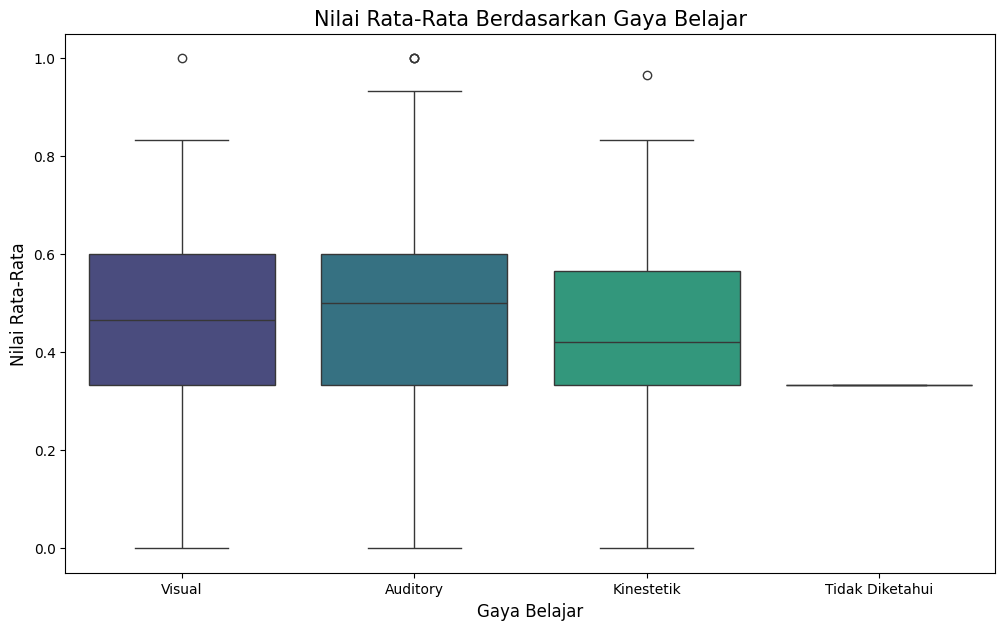


--- Rata-Rata Nilai per Gaya Belajar ---
Gaya_Belajar_Label
Auditory           0.474591
Visual             0.464915
Kinestetik         0.444515
Tidak Diketahui    0.333333
Name: Nilai_Rata_Rata, dtype: float64


In [43]:
# Buat kolom label singkat dari one-hot encoded
def get_gaya_belajar(row):
    if row['Gaya belajar yang biasanya digunakan_auditory'] == 1:
        return 'Auditory'
    elif row['Gaya belajar yang biasanya digunakan_visual'] == 1:
        return 'Visual'
    elif row['Gaya belajar yang biasanya digunakan_kinestetik'] == 1:
        return 'Kinestetik'
    else:
        return 'Tidak Diketahui'

df['Gaya_Belajar_Label'] = df.apply(get_gaya_belajar, axis=1)

# Boxplot rapi dengan label singkat
plt.figure(figsize=(12, 7))
sns.boxplot(
    x='Gaya_Belajar_Label',
    y='Nilai_Rata_Rata',
    data=df,
    palette='viridis'
)
plt.title('Nilai Rata-Rata Berdasarkan Gaya Belajar', fontsize=15)
plt.xlabel('Gaya Belajar', fontsize=12)
plt.ylabel('Nilai Rata-Rata', fontsize=12)
plt.show()

# Rata-rata nilai per gaya belajar (deskripsi lengkap)
avg_nilai_gaya = df.groupby('Gaya_Belajar_Label')['Nilai_Rata_Rata'].mean().sort_values(ascending=False)
print("\n--- Rata-Rata Nilai per Gaya Belajar ---")
print(avg_nilai_gaya)


/tmp/ipython-input-448462317.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


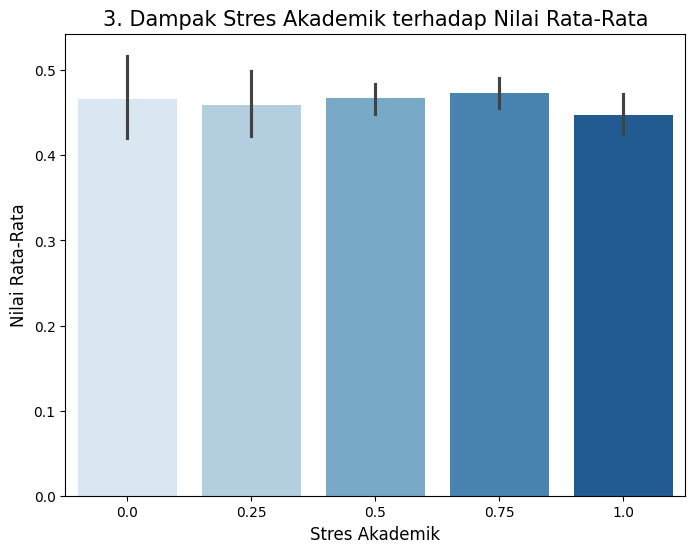


--- Rata-Rata Nilai per Tingkat Stres Akademik ---
Stres_Akademik
0.75    0.473014
0.50    0.467056
0.00    0.466836
0.25    0.459377
1.00    0.447851
Name: Nilai_Rata_Rata, dtype: float64
💡 Insight C: Analisis ini menunjukkan apakah tingkat stres (Rendah / Sedang / Tinggi) berpengaruh terhadap performa akademik siswa.


In [44]:
# C. Dampak Stres Akademik terhadap Nilai Rata-Rata
plt.figure(figsize=(8, 6))
sns.barplot(
    x='Stres_Akademik',
    y='Nilai_Rata_Rata',  # ✅ sesuaikan dengan nama kolom yang benar
    data=df,
    palette='Blues'
)
plt.title('3. Dampak Stres Akademik terhadap Nilai Rata-Rata', fontsize=15)
plt.xlabel('Stres Akademik', fontsize=12)
plt.ylabel('Nilai Rata-Rata', fontsize=12)
plt.show()

# Analisis rata-rata nilai berdasarkan tingkat stres
avg_nilai_stres = df.groupby('Stres_Akademik')['Nilai_Rata_Rata'].mean().sort_values(ascending=False)
print("\n--- Rata-Rata Nilai per Tingkat Stres Akademik ---")
print(avg_nilai_stres)

print("💡 Insight C: Analisis ini menunjukkan apakah tingkat stres (Rendah / Sedang / Tinggi) berpengaruh terhadap performa akademik siswa.")


/tmp/ipython-input-3706382186.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Stres_Akademik', y='Nilai_Rata_Rata', data=df, palette='Blues')


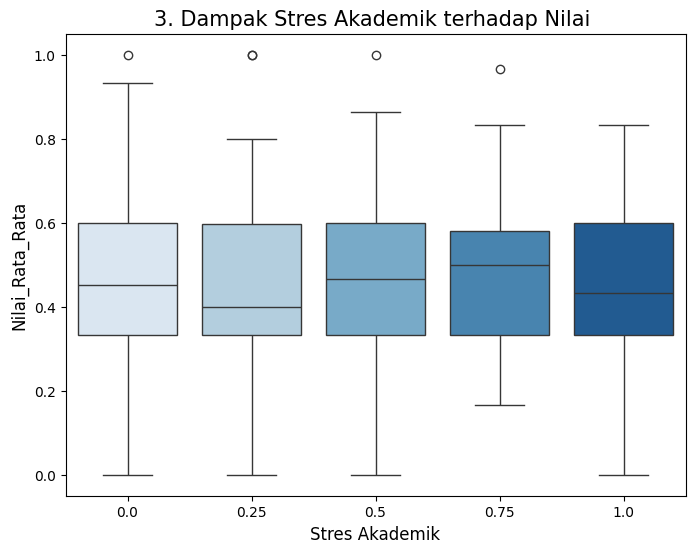

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mengatur ukuran grafik
plt.figure(figsize=(8, 6))

# Membuat boxplot untuk menunjukkan distribusi nilai rata-rata berdasarkan tingkat Stres Akademik
sns.boxplot(x='Stres_Akademik', y='Nilai_Rata_Rata', data=df, palette='Blues')

# Menambahkan judul dan label sumbu
plt.title('3. Dampak Stres Akademik terhadap Nilai ', fontsize=15)
plt.xlabel('Stres Akademik', fontsize=12)
plt.ylabel('Nilai_Rata_Rata', fontsize=12)

# Menampilkan grafik
plt.show()


/tmp/ipython-input-3128306465.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Mood Saat Belajar', y='Nilai_Rata_Rata', data=df, palette='coolwarm')


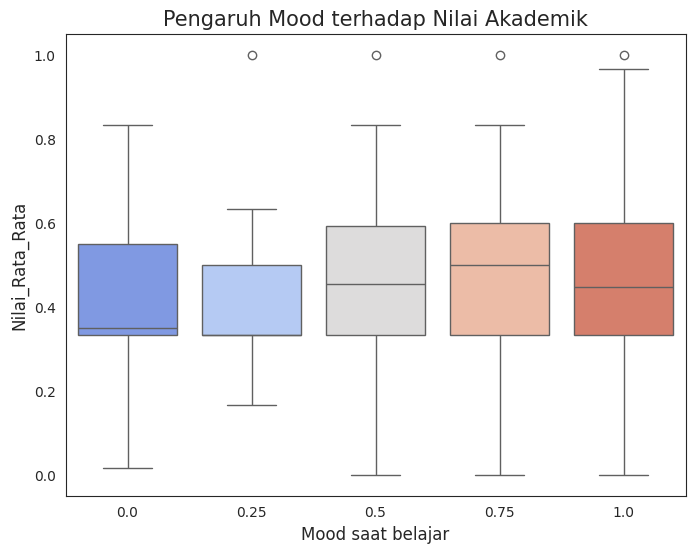

In [93]:
# Mengatur ukuran grafik
plt.figure(figsize=(8, 6))

# Membuat boxplot
sns.boxplot(x='Mood Saat Belajar', y='Nilai_Rata_Rata', data=df, palette='coolwarm')

# Menambahkan judul dan label
plt.title('Pengaruh Mood terhadap Nilai Akademik', fontsize=15)
plt.xlabel('Mood saat belajar', fontsize=12)
plt.ylabel('Nilai_Rata_Rata', fontsize=12)

# Menampilkan grafik
plt.show()


In [55]:
print(df[['Nilai_Rata_Rata','Waktu_Belajar_Mandiri','Mood Saat Belajar','Stres_Akademik']].dtypes)
print(df[['Nilai_Rata_Rata','Waktu_Belajar_Mandiri','Mood Saat Belajar','Stres_Akademik']].head(10))


Nilai_Rata_Rata          float64
Waktu_Belajar_Mandiri      int64
Mood Saat Belajar        float64
Stres_Akademik           float64
dtype: object
    Nilai_Rata_Rata  Waktu_Belajar_Mandiri  Mood Saat Belajar  Stres_Akademik
0          0.600000                      2               0.75            0.75
1          0.566667                      2               0.50            0.50
2          0.725000                      1               0.75            0.50
3          0.666667                      1               0.50            0.50
5          0.633333                      3               0.75            0.50
6          0.433333                      2               0.50            0.00
7          0.566667                      3               0.75            0.75
8          0.500000                      2               0.50            0.50
9          0.333333                      1               0.50            0.25
10         0.333333                      2               0.50            0

In [56]:
print(df.columns)

Index(['Timestamp', 'Nama Lengkap', 'Tingkat Kelas',
       'Apakah kamu belajar sendiri atau dengan bantuan orang lain?',
       'Total Waktu untuk mengerjakan Pekerjaan Rumah(PR)/Hari',
       'Waktu_Belajar_Mandiri', 'Catatan singkat tentang Belajar',
       'Mood Saat Belajar', 'Stres_Akademik', 'Nilai_Rata_Rata',
       'Jumlah prestasi di dalam sekolah *',
       'Prestasi yang diraih didalam sekolah',
       'Jumlah prestasi di luar sekolah',
       'Prestasi yang diraih diluar sekolah',
       'Gaya belajar yang biasanya digunakan_auditory',
       'Gaya belajar yang biasanya digunakan_kinestetik',
       'Gaya belajar yang biasanya digunakan_visual',
       'Teknik belajar yang biasanya digunakan_active_recall',
       'Teknik belajar yang biasanya digunakan_feynman',
       'Teknik belajar yang biasanya digunakan_latihan_soal',
       'Teknik belajar yang biasanya digunakan_podomoro',
       'Teknik belajar yang biasanya digunakan_spaced_repetition',
       'Jenis Kelamin_lak

Evaluasi Random Forest:
{'RMSE': np.float64(0.1737285862621706), 'MAE': 0.1372505289947099, 'R2': -0.12173762768786478}

Top 10 Faktor Paling Berpengaruh:
                                              Faktor  Pengaruh
3                                     Stres_Akademik  0.206989
2                                  Mood Saat Belajar  0.192774
0  Total Waktu untuk mengerjakan Pekerjaan Rumah(...  0.170937
1                              Waktu_Belajar_Mandiri  0.162456
5                    Jumlah prestasi di luar sekolah  0.137622
4                 Jumlah prestasi di dalam sekolah *  0.129222


/tmp/ipython-input-132508204.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


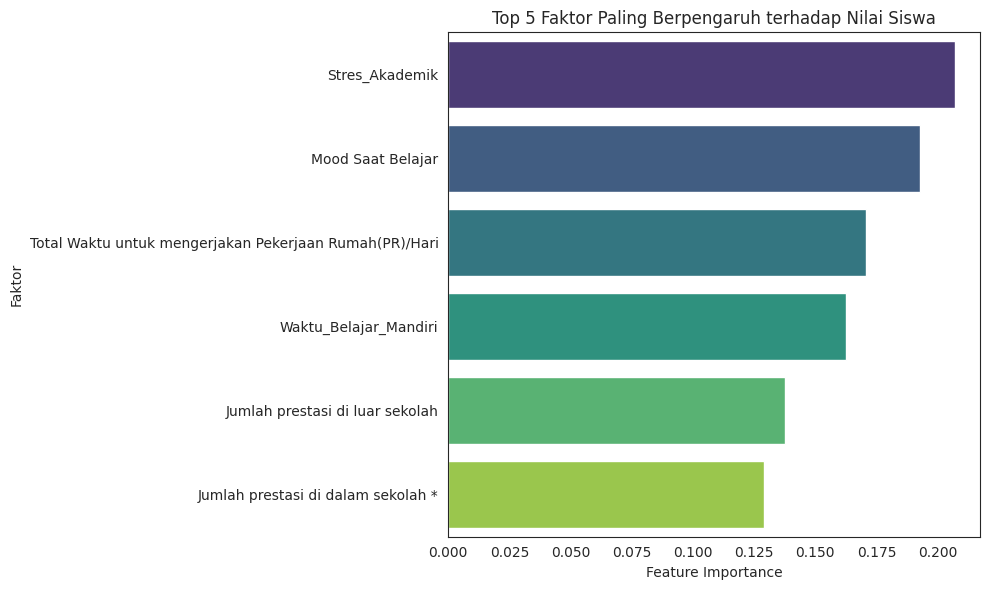


Cross-Validation R2 Scores: [-0.29851248 -0.67698736 -0.1428832  -0.19172419 -0.51973122]
Mean R2: -0.3659676899590341


In [92]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# ================================
# 4️⃣ Siapkan Data Modeling
# ================================
target = "Nilai_Rata_Rata"
X = df.drop(columns=[target])
y = df[target]

# Hanya ambil numeric features
X = X.select_dtypes(include=np.number)

# Split data 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ================================
# 5️⃣ Train Random Forest
# ================================
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# ================================
# 6️⃣ Prediksi & Evaluasi
# ================================
def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"RMSE": rmse, "MAE": mae, "R2": r2}

y_pred = rf.predict(X_test)
metrics = evaluate(y_test, y_pred)
print("Evaluasi Random Forest:")
print(metrics)

# ================================
# 7️⃣ Feature Importance
# ================================
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    "Faktor": X.columns,
    "Pengaruh": importances
}).sort_values(by="Pengaruh", ascending=False)

print("\nTop 10 Faktor Paling Berpengaruh:")
print(feature_importance_df.head(10))

# ================================
# 8️⃣ Visualisasi Feature Importance
# ================================
plt.figure(figsize=(10,6))
sns.barplot(
    data=feature_importance_df.head(10),
    x="Pengaruh",
    y="Faktor",
    palette="viridis"
)
plt.title("Top 5 Faktor Paling Berpengaruh terhadap Nilai Siswa")
plt.xlabel("Feature Importance")
plt.ylabel("Faktor")
plt.tight_layout()
plt.show()

# ================================
# 9️⃣ Cross-Validation
# ================================
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
print("\nCross-Validation R2 Scores:", cv_scores)
print("Mean R2:", cv_scores.mean())


In [91]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Pastikan hanya numerik
df_model = df.select_dtypes(include=np.number).dropna()

target = "Nilai_Rata_Rata"
X = df_model.drop(columns=[target])
y = df_model[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Model
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=100, random_state=42)

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Prediksi
y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)

# Evaluasi
def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    }

print("Linear Regression:", evaluate(y_test, y_pred_lr))
print("Random Forest:", evaluate(y_test, y_pred_rf))


Linear Regression: {'RMSE': np.float64(0.16062029578960674), 'MAE': 0.13424767892183656, 'R2': 0.04115245696698622}
Random Forest: {'RMSE': np.float64(0.1737285862621706), 'MAE': 0.1372505289947099, 'R2': -0.12173762768786478}


/tmp/ipython-input-2573418390.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Rata_Rata_Nilai', y='Teknik', data=df_teknik, palette='magma')


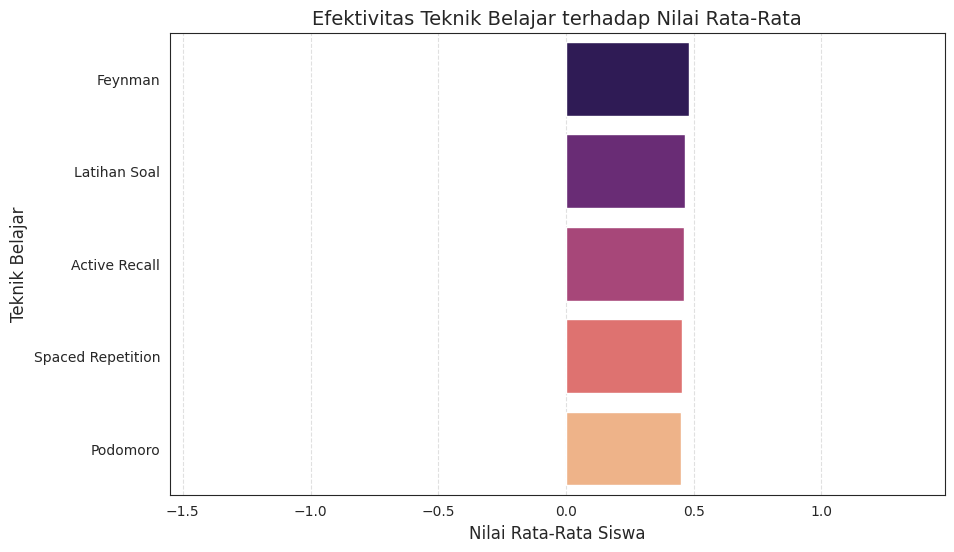

💡 Insight: Teknik Feynman memberikan rata-rata nilai tertinggi yaitu 0.48


In [90]:
# Efektivitas Teknik Belajar yang paling ampuh
teknik_cols = [
    'Teknik belajar yang biasanya digunakan_active_recall',
    'Teknik belajar yang biasanya digunakan_feynman',
    'Teknik belajar yang usually digunakan_latihan_soal',
    'Teknik belajar yang biasanya digunakan_latihan_soal',
    'Teknik belajar yang biasanya digunakan_podomoro',
    'Teknik belajar yang biasanya digunakan_spaced_repetition'
]

teknik_performance = []

target_col = 'Nilai_Rata_Rata'

for col in teknik_cols:
    if col in df.columns:
        nama_teknik = col.replace('Teknik belajar yang biasanya digunakan_', '').replace('_', ' ').title()

        avg_score = df[df[col] == 1][target_col].mean()

        if pd.notnull(avg_score):
            teknik_performance.append({'Teknik': nama_teknik, 'Rata_Rata_Nilai': avg_score})

df_teknik = pd.DataFrame(teknik_performance).sort_values(by='Rata_Rata_Nilai', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Rata_Rata_Nilai', y='Teknik', data=df_teknik, palette='magma')

plt.title('Efektivitas Teknik Belajar terhadap Nilai Rata-Rata', fontsize=14)
plt.xlabel('Nilai Rata-Rata Siswa', fontsize=12)
plt.ylabel('Teknik Belajar', fontsize=12)

if not df_teknik.empty:
    min_val = df_teknik['Rata_Rata_Nilai'].min()
    max_val = df_teknik['Rata_Rata_Nilai'].max()
    plt.xlim(min_val - 2, max_val + 1)

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

print(f"💡 Insight: Teknik {df_teknik.iloc[0]['Teknik']} memberikan rata-rata nilai tertinggi yaitu {df_teknik.iloc[0]['Rata_Rata_Nilai']:.2f}")

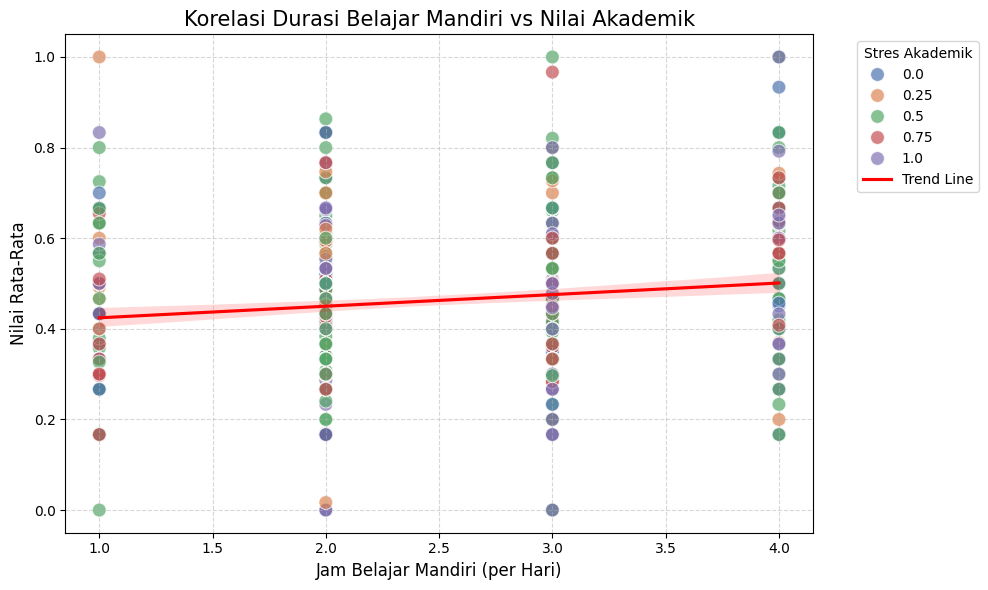

Insight: Durasi belajar berkontribusi positif pada nilai.


In [68]:
# Hubungan Durasi Belajar Mandiri vs Nilai (Scatter Plot)

plt.figure(figsize=(10, 6))

sns.scatterplot(
    x='Waktu_Belajar_Mandiri',
    y='Nilai_Rata_Rata',
    data=df,
    hue='Stres_Akademik',
    palette='deep',
    s=100,
    alpha=0.7
)

sns.regplot(
    x='Waktu_Belajar_Mandiri',
    y='Nilai_Rata_Rata',
    data=df,
    scatter=False,
    color='red',
    label='Trend Line'
)

plt.title('Korelasi Durasi Belajar Mandiri vs Nilai Akademik', fontsize=15)
plt.xlabel('Jam Belajar Mandiri (per Hari)', fontsize=12)
plt.ylabel('Nilai Rata-Rata', fontsize=12)
plt.legend(title='Stres Akademik', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("Insight: Durasi belajar berkontribusi positif pada nilai.")

/tmp/ipython-input-325946731.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py:3399: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py:3399: UserWarning: 28.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py:3399: UserWarning: 14.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py:3399: UserWarning: 34.0% of the points c

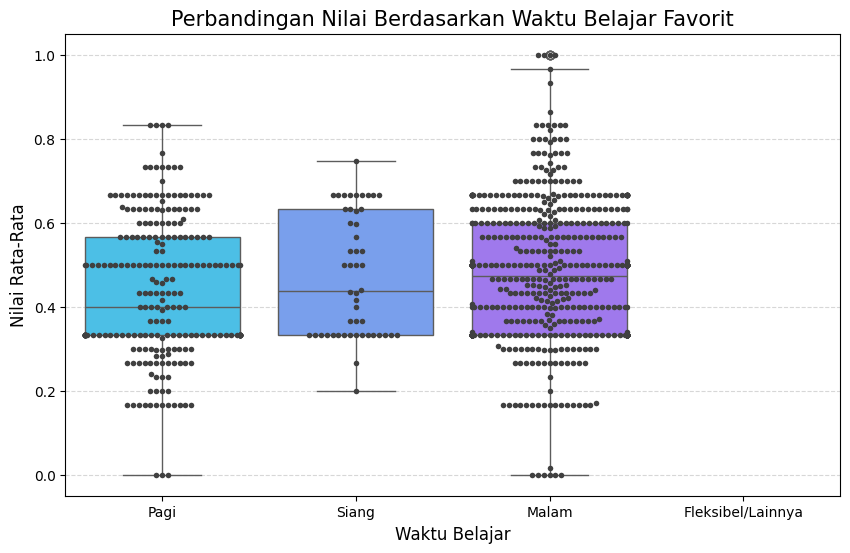

In [70]:
# Waktu Belajar (Pagi/Siang/Malam) vs Performa


def get_waktu_belajar(row):
    if row['Jam Belajar_pagi'] == 1:
        return 'Pagi'
    elif row['Jam Belajar_siang'] == 1:
        return 'Siang'
    elif row['Jam Belajar_malam'] == 1:
        return 'Malam'
    else:
        return 'Fleksibel/Lainnya'

df['Waktu_Belajar_Label'] = df.apply(get_waktu_belajar, axis=1)

# Visualisasi Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='Waktu_Belajar_Label',
    y='Nilai_Rata_Rata',
    data=df,
    palette='cool',
    order=['Pagi', 'Siang', 'Malam', 'Fleksibel/Lainnya']
)

sns.swarmplot(
    x='Waktu_Belajar_Label',
    y='Nilai_Rata_Rata',
    data=df,
    color=".25",
    size=4,
    order=['Pagi', 'Siang', 'Malam', 'Fleksibel/Lainnya']
)

plt.title('Perbandingan Nilai Berdasarkan Waktu Belajar Favorit', fontsize=15)
plt.xlabel('Waktu Belajar', fontsize=12)
plt.ylabel('Nilai Rata-Rata', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

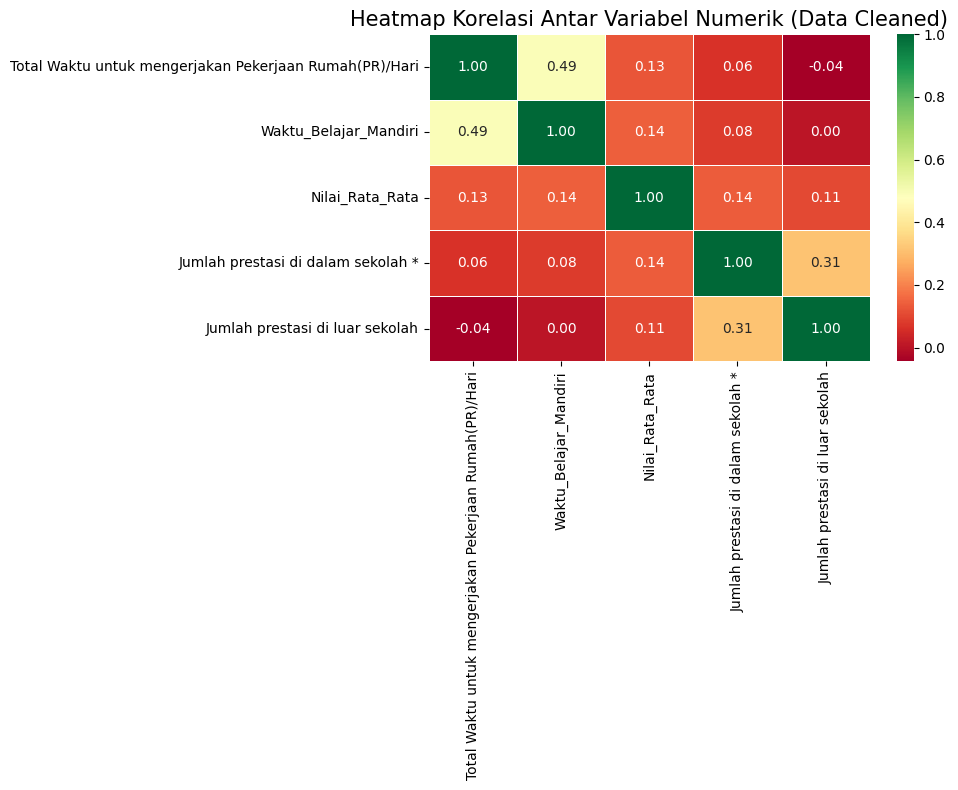

In [66]:
# Korelasi Prestasi (Heatmap)

cols_corr = [
    'Total Waktu untuk mengerjakan Pekerjaan Rumah(PR)/Hari',
    'Waktu_Belajar_Mandiri',
    'Nilai_Rata_Rata',
    'Jumlah prestasi di dalam sekolah *',
    'Jumlah prestasi di luar sekolah'
]

for col in cols_corr:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace('tidak ada', '0', case=False), errors='coerce')

df[cols_corr] = df[cols_corr].fillna(0)

correlation_matrix = df[cols_corr].corr()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='RdYlGn', # Hijau (positif), Kuning (netral), Merah (negatif)
    fmt=".2f",
    linewidths=0.5
)

plt.title('Heatmap Korelasi Antar Variabel Numerik (Data Cleaned)', fontsize=15)
plt.tight_layout()
plt.show()

/tmp/ipython-input-4209000475.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


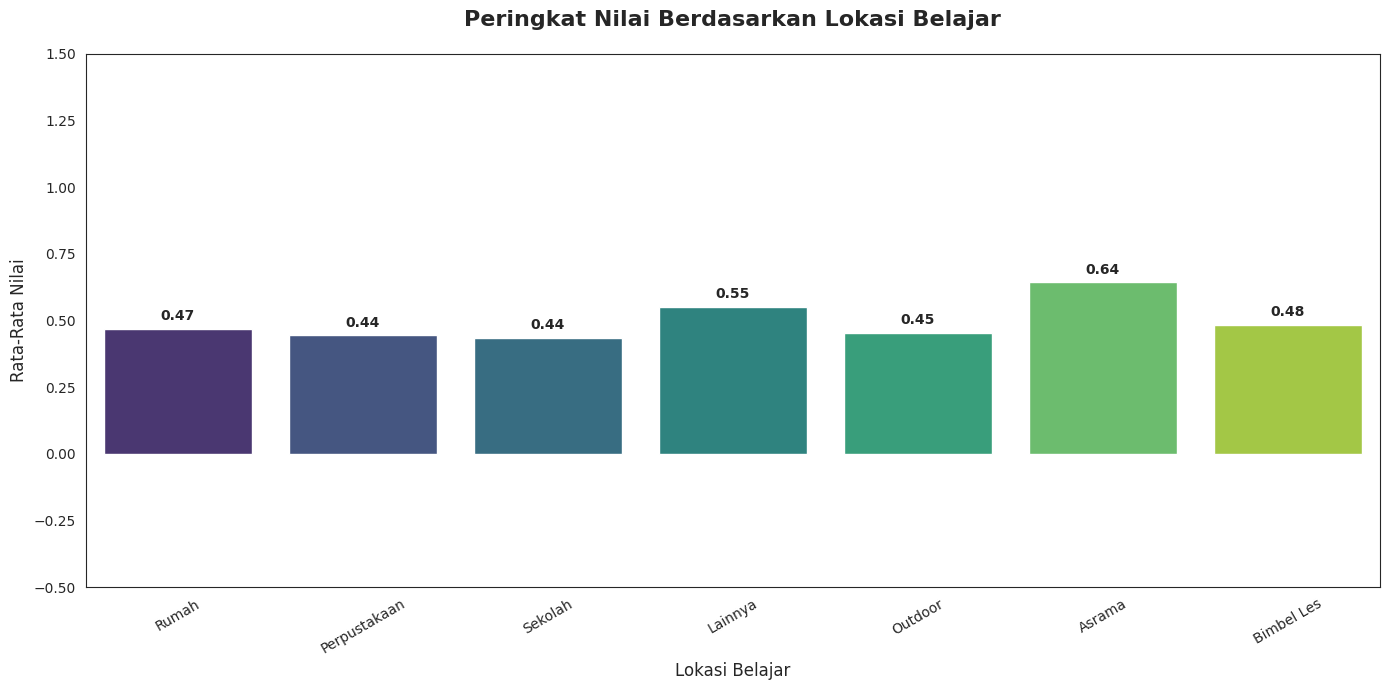

In [98]:
# Analisis Lingkungan Belajar

plt.figure(figsize=(14, 7))
sns.set_style("white")

ax = sns.barplot(
    x='Lokasi_Utama',
    y='Nilai_Rata_Rata',
    data=df,
    palette='viridis',
    errorbar=None
)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points',
                fontweight='bold')

y_min = df['Nilai_Rata_Rata'].min()
y_max = df['Nilai_Rata_Rata'].max()
plt.ylim(y_min - 0.5, y_max + 0.5)

plt.title('Peringkat Nilai Berdasarkan Lokasi Belajar', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=30)
plt.xlabel('Lokasi Belajar', fontsize=12)
plt.ylabel('Rata-Rata Nilai', fontsize=12)
plt.tight_layout()
plt.show()

/tmp/ipython-input-4203247573.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py:3399: UserWarning: 12.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py:3399: UserWarning: 13.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py:3399: UserWarning: 15.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py:3399: UserWarning: 15.4% of the points c

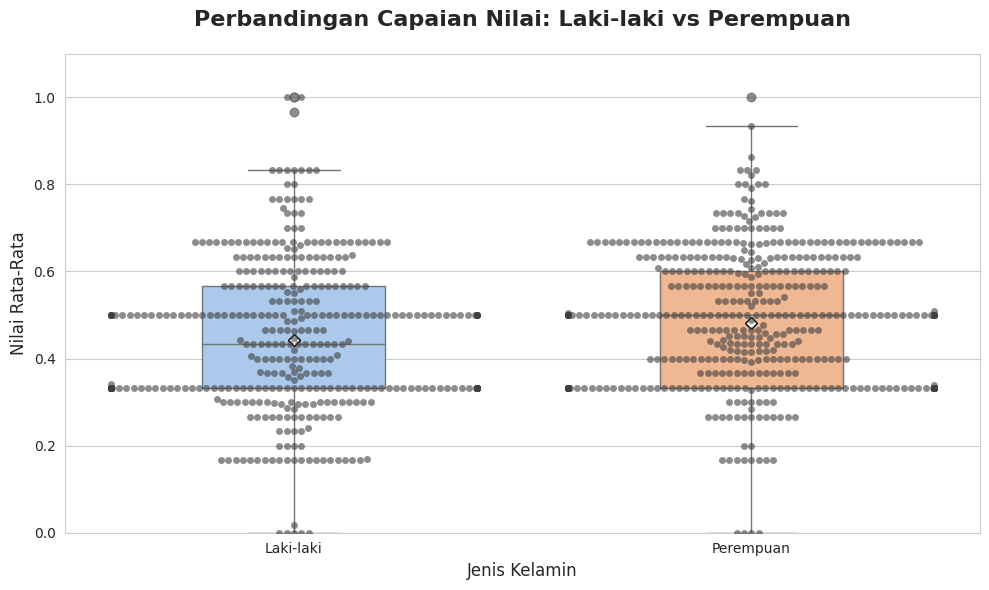

In [96]:
# Analisis Gender & Performa (Violin Plot)

df['Nilai_Rata_Rata'] = pd.to_numeric(df['Nilai_Rata_Rata'], errors='coerce')

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.boxplot(
    x='Gender_Label',
    y='Nilai_Rata_Rata',
    data=df,
    palette='pastel',
    width=0.4,
    showmeans=True,
    meanprops={"marker":"D", "markerfacecolor":"white", "markeredgecolor":"black"}
)

sns.swarmplot(
    x='Gender_Label',
    y='Nilai_Rata_Rata',
    data=df,
    color=".25",
    size=5,
    alpha=0.6
)

min_val = df['Nilai_Rata_Rata'].min()
max_val = df['Nilai_Rata_Rata'].max()

plt.ylim(min_val - (min_val * 0.1), max_val + (max_val * 0.1))

plt.title('Perbandingan Capaian Nilai: Laki-laki vs Perempuan', fontsize=16, pad=20, fontweight='bold')
plt.xlabel('Jenis Kelamin', fontsize=12)
plt.ylabel('Nilai Rata-Rata', fontsize=12)

plt.tight_layout()
plt.show()

/tmp/ipython-input-2481184157.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py:3399: UserWarning: 20.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py:3399: UserWarning: 26.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py:3399: UserWarning: 19.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py:3399: UserWarning: 37.7% of the points c

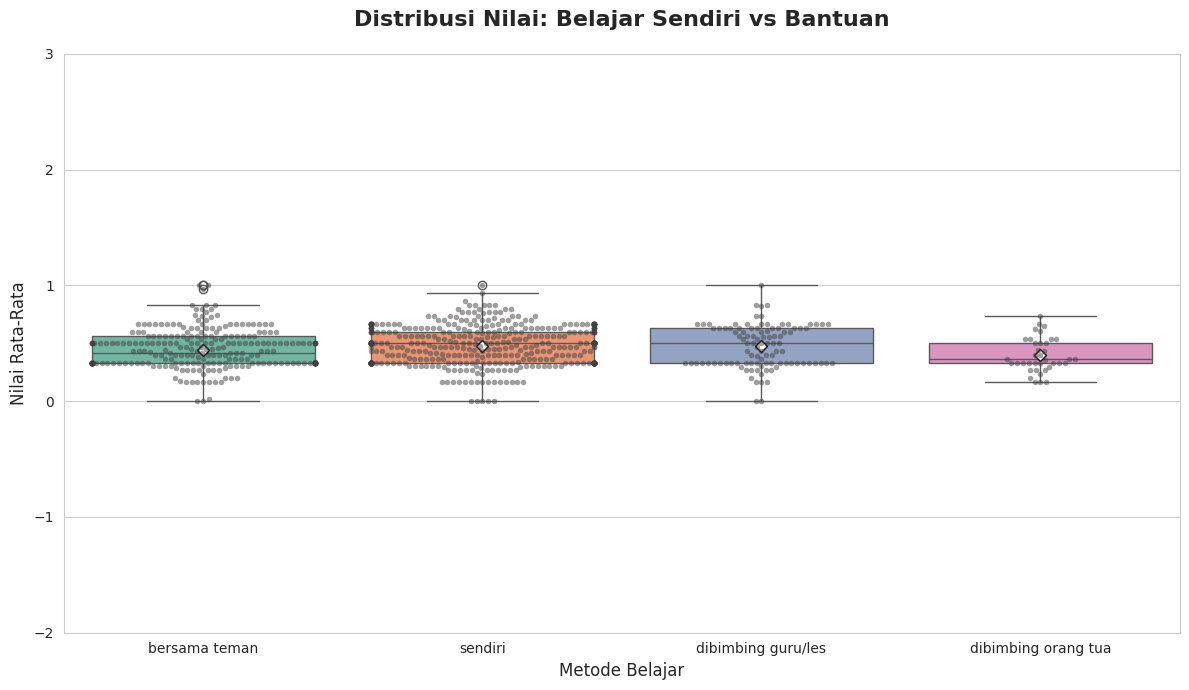

In [95]:
# Pengaruh Bantuan Belajar (Sosial vs Mandiri)

col_x = 'Apakah kamu belajar sendiri atau dengan bantuan orang lain?'
col_y = 'Nilai_Rata_Rata'

plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

sns.boxplot(
    x=col_x,
    y=col_y,
    data=df,
    palette='Set2',
    showmeans=True,
    meanprops={"marker":"D", "markerfacecolor":"white", "markeredgecolor":"black"}
)

sns.swarmplot(
    x=col_x,
    y=col_y,
    data=df,
    color=".25",
    size=4,
    alpha=0.5
)

plt.title('Distribusi Nilai: Belajar Sendiri vs Bantuan', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Metode Belajar', fontsize=12)
plt.ylabel('Nilai Rata-Rata', fontsize=12)

y_min = df[col_y].min()
y_max = df[col_y].max()
plt.ylim(y_min - 2, y_max + 2)

plt.tight_layout()
plt.show()

#Model 1: Regression (Memprediksi Nilai)

In [ ]:
def get_gaya_belajar(row):
    if row.get('Gaya belajar yang biasanya digunakan_auditory', 0) == 1:
        return 'Auditory'
    elif row.get('Gaya belajar yang biasanya digunakan_visual', 0) == 1:
        return 'Visual'
    elif row.get('Gaya belajar yang biasanya digunakan_kinestetik', 0) == 1:
        return 'Kinestetik'
    else:
        return 'Tidak Diketahui'

df['Gaya_Belajar_Label'] = df.apply(get_gaya_belajar, axis=1)


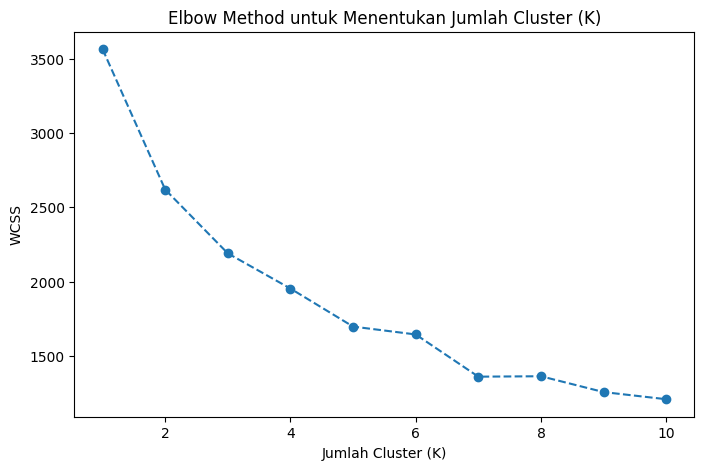

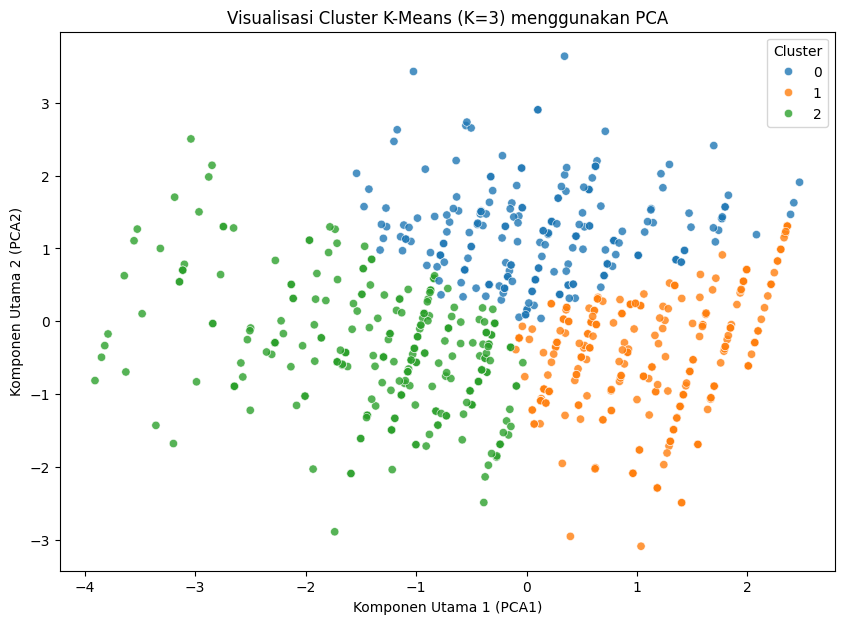


--- Profil Rata-rata Setiap Cluster ---
         Nilai_Rata_Rata  Waktu_Belajar_Mandiri  Mood Saat Belajar  \
Cluster                                                              
0.0             0.627820               3.146444           0.705021   
1.0             0.438871               2.632353           0.902941   
2.0             0.401804               1.910256           0.483173   

         Stres_Akademik  
Cluster                  
0.0            0.510460  
1.0            0.858824  
2.0            0.421474  

--- Distribusi Gaya Belajar di Setiap Cluster ---

Cluster 0:
Gaya_Belajar_Label
Auditory      0.523013
Kinestetik    0.305439
Visual        0.171548
Name: proportion, dtype: float64

Cluster 1:
Gaya_Belajar_Label
Auditory      0.523529
Kinestetik    0.297059
Visual        0.179412
Name: proportion, dtype: float64

Cluster 2:
Gaya_Belajar_Label
Auditory           0.455128
Kinestetik         0.330128
Visual             0.211538
Tidak Diketahui    0.003205
Name: proportion, 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# --- 1. Pilih fitur untuk clustering ---
# Gunakan variabel numerik / ordinal penting
X = df[['Nilai_Rata_Rata', 'Waktu_Belajar_Mandiri', 'Mood Saat Belajar', 'Stres_Akademik']].copy()

# Konversi 'Waktu_Belajar_Mandiri' ke menit jika belum
# Misal: df['Waktu_Belajar_Mandiri'] sudah ada konversi ke menit
# Pastikan tidak ada string di X
X = X.apply(pd.to_numeric, errors='coerce')
X = X.dropna()  # hilangkan baris dengan nilai yang tidak bisa dikonversi

# --- 2. Scaling data ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 3. Menentukan jumlah cluster optimal (Elbow Method) ---
wcss = []
max_k = 10
for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, max_k + 1), wcss, marker='o', linestyle='--')
plt.title('Elbow Method untuk Menentukan Jumlah Cluster (K)')
plt.xlabel('Jumlah Cluster (K)')
plt.ylabel('WCSS')
plt.show()

# --- 4. Latih K-Means dengan K optimal ---
optimal_k = 3  # misal hasil Elbow Method menunjuk 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(X_scaled)

# --- 5. Reduksi dimensi untuk visualisasi 2D dengan PCA ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_pca['Cluster'] = clusters

# Visualisasi cluster
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', data=df_pca,
    palette=sns.color_palette('tab10', optimal_k),
    legend='full', alpha=0.8
)
plt.title(f'Visualisasi Cluster K-Means (K={optimal_k}) menggunakan PCA')
plt.xlabel('Komponen Utama 1 (PCA1)')
plt.ylabel('Komponen Utama 2 (PCA2)')
plt.show()

# --- 6. Interpretasi cluster ---
df.loc[X.index, 'Cluster'] = clusters  # tambahkan label cluster ke DataFrame asli

cluster_profile = df.groupby('Cluster')[['Nilai_Rata_Rata', 'Waktu_Belajar_Mandiri', 'Mood Saat Belajar', 'Stres_Akademik']].mean()
print("\n--- Profil Rata-rata Setiap Cluster ---")
print(cluster_profile)

print("\n--- Distribusi Gaya Belajar di Setiap Cluster ---")
for c in range(optimal_k):
    print(f"\nCluster {c}:")
    print(df[df['Cluster']==c]['Gaya_Belajar_Label'].value_counts(normalize=True))


In [ ]:
#🔮 Tahap 5: Predictive Analytics & Rekomendasi

In [ ]:
#Gunakan best_model (misalnya, Random Forest) untuk memprediksi nilai dan memberikan rekomendasi terukur.

In [ ]:
# Pastikan menggunakan model terbaik yang telah dilatih (best_model) dan scaler dari tahap 4
# Asumsikan 'best_model' adalah Random Forest Regressor yang sudah dilatih

# 1. Rekomendasi Skenario: Belajar 60 menit + Teknik Tertentu
def get_prediction_for_scenario(model, input_data_dict):
    # Buat DataFrame dari input data
    new_data = pd.DataFrame([input_data_dict])

    # Lakukan One-Hot Encoding pada input baru (harus sama dengan kolom training X)
    # Ini adalah langkah KRITIS: tambahkan semua kolom yang ada di X, set nilai ke 0 atau 1
    new_data_encoded = pd.get_dummies(new_data)

    # Tambahkan kolom yang hilang dan set ke 0
    missing_cols = set(X.columns) - set(new_data_encoded.columns)
    for c in missing_cols:
        new_data_encoded[c] = 0

    # Pastikan urutan kolom sama persis dengan data training (X)
    new_data_encoded = new_data_encoded[X.columns]

    # Prediksi
    return model.predict(new_data_encoded)[0]

# Tentukan skenario dasar (misalnya, nilai rata-rata dari semua siswa)
base_scenario = X_raw.mean().to_dict()
base_scenario['Gaya_Belajar'] = X_raw['Gaya_Belajar'].mode()[0]
base_scenario['Teknik_Belajar'] = X_raw['Teknik_Belajar'].mode()[0]
base_scenario['Jam_Belajar'] = X_raw['Jam_Belajar'].mode()[0]

# Skenario 1: Peningkatan Durasi dan Gaya Belajar Tertentu
# Asumsi: Waktu Mandiri dinaikkan ke 60 menit (45) dan Gaya Belajar Visual (nilai mode)
scenario_1 = base_scenario.copy()
scenario_1['Waktu_Mandiri_Menit'] = 60 # Skenario 60 menit

# Prediksi untuk Skenario 1
pred_nilai_1 = get_prediction_for_scenario(best_model, scenario_1)
print(f"Rekomendasi Prediksi: Belajar 60 menit (Waktu Mandiri) + Gaya {scenario_1['Gaya_Belajar']} -> prediksi nilai = {pred_nilai_1:.2f}")


# 2. Rekomendasi Berbasis Insight (Jam Belajar)
# Hitung rata-rata nilai berdasarkan Jam Belajar dari EDA (Tahap 3)
nilai_per_jam = df.groupby('Jam_Belajar')['Nilai_Akhir'].mean().sort_values(ascending=False)

if 'Pagi' in nilai_per_jam.index and 'Malam' in nilai_per_jam.index:
    peningkatan_pagi = nilai_per_jam['Pagi'] - nilai_per_jam['Malam']

    print(f"\nRekomendasi Berbasis Insight:")
    print(f"Nilai Rata-Rata Belajar Pagi: {nilai_per_jam['Pagi']:.2f}")
    print(f"Nilai Rata-Rata Belajar Malam: {nilai_per_jam['Malam']:.2f}")
    print(f"Rekomendasi: Belajar Pagi meningkatkan nilai rata-rata sebesar {peningkatan_pagi:.2f} poin dibandingkan Belajar Malam.")
else:
    print("\nData Jam Belajar tidak mencukupi untuk perbandingan ini.")